### Conditional density estimation

This example shows how we can perform conditional density estimation with normalising flows.
Here we use a [BlockNeuralAutoregressiveFlow](../api/flows.rst#flowjax.flows.BlockNeuralAutoregressiveFlow),
although other flows are available (see [flowjax.flows](../api/flows.rst)). We consider a two dimensional model, where the upper limit of the target uniform distribution depends on another uniform random variable:
$$u_i \sim \text{Uniform}(0,5) \quad \text{for}\ i\ \text{in}\ 1,2$$
$$x_i \sim \text{Uniform}(0, u_i), \quad \text{for}\ i\ \text{in}\ 1,2$$

We will try to infer the conditional distribution $p(x|u)$ using samples from the model.


#### Imports and data generation
Importing the required packages

In [18]:
import jax.random as jr
import jax.numpy as jnp
import numpy as onp
from flowjax.flows import BlockNeuralAutoregressiveFlow
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt

Generating the data

In [19]:
key, x_key, cond_key = jr.split(jr.PRNGKey(0), 3)
u = jr.uniform(cond_key, (10000, 2), minval=0, maxval=5)
x = jr.uniform(x_key, shape=u.shape, maxval=u)

#### Create and train flow

In [20]:
key, subkey = jr.split(jr.PRNGKey(0))

flow = BlockNeuralAutoregressiveFlow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    cond_dim=u.shape[1],
)

key, subkey = jr.split(key)
flow, losses = train_flow(subkey, flow, x, u, learning_rate=1e-2)

 60%|██████    | 30/50 [00:07<00:04,  4.08it/s, train=1.31, val=1.27 (Max patience reached)]


#### Visualize learned conditional density
Let's condition on $u=[1,3]'$, in which case we expect $x_1 \sim \text{Uniform}(0, 1)$ and $x_2 \sim \text{Uniform}(0, 3)$

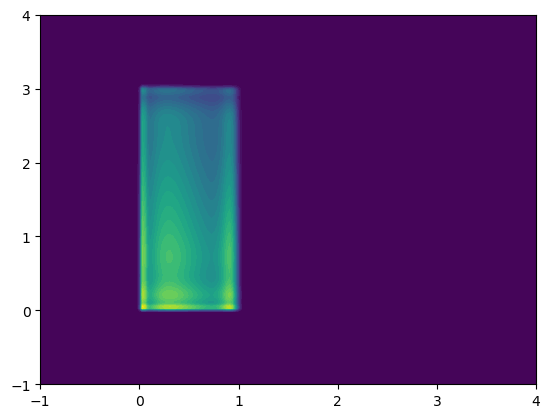

In [21]:
resolution = 200
test_u = jnp.array([1.0, 3])

xgrid, ygrid = jnp.meshgrid(
    jnp.linspace(-1, 4, resolution),
    jnp.linspace(-1, 4, resolution)
    )
xyinput = jnp.column_stack((xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)))
zgrid = jnp.exp(flow.log_prob(xyinput, test_u).reshape(resolution, resolution))
plt.contourf(xgrid, ygrid, zgrid, levels=40)
plt.show()